In [76]:
using JLD, Plots, Combinatorics
using Base.Iterators
gr()

Plots.GRBackend()

In [2]:
arxname="../JLDFiles/Evocada/CSDEvocada_3R7.jld"
data=load(arxname)

Dict{String,Any} with 2 entries:
  "CSDPlanchada" => Dict{AbstractString,Array}("Trancazo_2"=>[-18.0116 -6.93308…
  "CSD"          => Dict{AbstractString,Array}("Trancazo_2"=>[-26.8791 -3.68286…

In [153]:
freq=7.022
csd=(data["CSD"]["Trancazo_1"]+data["CSD"]["Trancazo_2"]+data["CSD"]["Trancazo_3"])./3
(h,w,nmax)=size(csd)
epsi=21

21

In [8]:
function simboliza(x, delta=epsi)
    result=0
    if x>delta
        result=1
    elseif x< -delta
        result=-1
    else
        result=0
    end
    return result
end

simboliza (generic function with 2 methods)

In [10]:
csdsymb=map(x->simboliza(x), csd);

In [21]:
sumsym=zeros(h,w)
    for j=1:h, k=1:w
    sumsym[j,k]=sum(abs.(csdsymb[j,k,:]))
end

In [115]:
function problock(xxs::Array, yys::Array)
    # calculamos la prob exp de encontrar el array yys en el array xxs
    lx=length(xxs)
    ly=length(yys)
    lp=lx-ly+1
    result=0
    if(lx<ly)
        error("tuabueliuta")
    else
        for j=1:lp
            if xxs[j:j+ly-1]==yys
                result+=1
            end
        end
    end
    return result/lp
end

problock (generic function with 1 method)

In [116]:
function ncartprod(ss, n)
    argumento=fill(ss, n)
    result=collect(product(argumento...))
    return(result)
end

ncartprod (generic function with 1 method)

In [154]:
function allprobsn(xxs, ss, n)
    result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    for p in palabras
        pr=[p...]
        result[pr]=problock(xxs, pr)
    end
    return result
end


allprobsn (generic function with 1 method)

In [163]:
function shanonH_n(xxs, ss, n)
    probs=allprobsn(xxs,ss,n)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h
    return result
end

shanonH_n (generic function with 1 method)

In [164]:
nm=div(nmax,2)
hhsn=zeros(h,w,nm)
@time for n=1:4
    for j=1:h, k=1:w
        xs=csdsymb[j,k,:]
        ss=[-1,0,1]
        hhsn[j,k,n]=shanonH_n(xs, ss, n)
    end
end

  7.286416 seconds (115.33 M allocations: 11.818 GiB, 31.93% gc time)


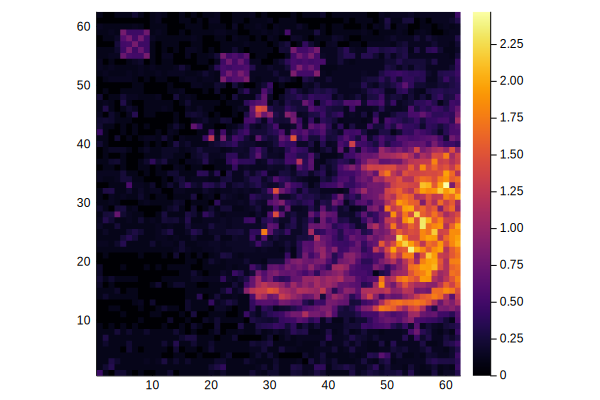

In [166]:
heatmap(hhsn[:,:,4], aspect_ratio=1)

In [ ]:
hhsn[:,:,1]==hhsn[:,:,4]

In [145]:
allprobsn(xs, ss, 3)

Dict{Array,Float64} with 27 entries:
  [1, -1, -1] => 0.0
  [0, -1, -1] => 0.0121951
  [-1, -1, 0] => 0.0121951
  [-1, 1, 1]  => 0.0
  [-1, 1, 0]  => 0.0
  [0, 0, 0]   => 0.902439
  [-1, 0, -1] => 0.00406504
  [1, 0, -1]  => 0.0
  [1, 0, 1]   => 0.0
  [-1, -1, 1] => 0.0
  [1, 1, 1]   => 0.0
  [0, 1, -1]  => 0.0
  [1, -1, 0]  => 0.0
  [0, 1, 0]   => 0.00813008
  [-1, 0, 1]  => 0.0
  [0, -1, 0]  => 0.00406504
  [1, 0, 0]   => 0.0121951
  [0, 0, 1]   => 0.0121951
  [1, -1, 1]  => 0.0
  [1, 1, -1]  => 0.0
  [1, 1, 0]   => 0.00406504
  [0, -1, 1]  => 0.0
  [-1, 0, 0]  => 0.0121951
  [-1, 1, -1] => 0.0
  [0, 0, -1]  => 0.0121951
  ⋮           => ⋮

In [68]:
ss=[-1,0,1]
bla=[[q, j] for q in ss, j in ss ]

3×3 Array{Array{Int64,1},2}:
 [-1, -1]  [-1, 0]  [-1, 1]
 [0, -1]   [0, 0]   [0, 1] 
 [1, -1]   [1, 0]   [1, 1] 

In [28]:
xs=csdsymb[16,42,:];
ys=[1]

1-element Array{Int64,1}:
 1

In [31]:
problock(xs, [1]) , problock(xs, [0]),problock(xs, [-1])

(0.016129032258064516, 0.9556451612903226, 0.028225806451612902)

search: permute! invpermute! permutedims! permutedims PermutedDimsArray



```
permute!(v, p)
```

Permute vector `v` in-place, according to permutation `p`. No checking is done to verify that `p` is a permutation.

To return a new permutation, use `v[p]`. Note that this is generally faster than `permute!(v,p)` for large vectors.

See also [`invpermute!`](@ref).

# Examples

```jldoctest
julia> A = [1, 1, 3, 4];

julia> perm = [2, 4, 3, 1];

julia> permute!(A, perm);

julia> A
4-element Array{Int64,1}:
 1
 4
 3
 1
```

---

```
permute!(X::SparseMatrixCSC{Tv,Ti}, A::SparseMatrixCSC{Tv,Ti},
         p::AbstractVector{<:Integer}, q::AbstractVector{<:Integer},
         [C::SparseMatrixCSC{Tv,Ti}]) where {Tv,Ti}
```

Bilaterally permute `A`, storing result `PAQ` (`A[p,q]`) in `X`. Stores intermediate result `(AQ)^T` (`transpose(A[:,q])`) in optional argument `C` if present. Requires that none of `X`, `A`, and, if present, `C` alias each other; to store result `PAQ` back into `A`, use the following method lacking `X`:

```
permute!(A::SparseMatrixCSC{Tv,Ti}, p::AbstractVector{<:Integer},
         q::AbstractVector{<:Integer}[, C::SparseMatrixCSC{Tv,Ti},
         [workcolptr::Vector{Ti}]]) where {Tv,Ti}
```

`X`'s dimensions must match those of `A` (`X.m == A.m` and `X.n == A.n`), and `X` must have enough storage to accommodate all allocated entries in `A` (`length(X.rowval) >= nnz(A)` and `length(X.nzval) >= nnz(A)`). Column-permutation `q`'s length must match `A`'s column count (`length(q) == A.n`). Row-permutation `p`'s length must match `A`'s row count (`length(p) == A.m`).

`C`'s dimensions must match those of `transpose(A)` (`C.m == A.n` and `C.n == A.m`), and `C` must have enough storage to accommodate all allocated entries in `A` (`length(C.rowval) >= nnz(A)` and `length(C.nzval) >= nnz(A)`).

For additional (algorithmic) information, and for versions of these methods that forgo argument checking, see (unexported) parent methods `unchecked_noalias_permute!` and `unchecked_aliasing_permute!`.

See also: [`permute`](@ref).


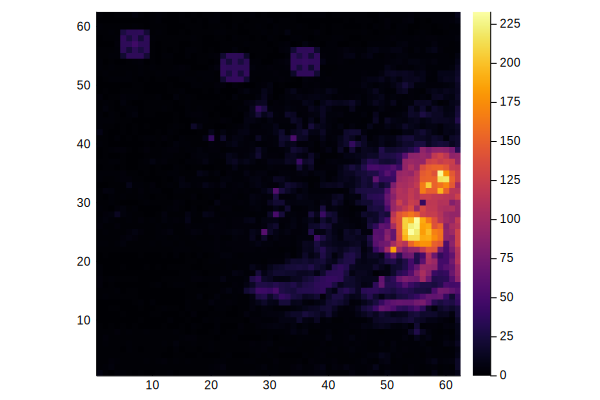

In [22]:
heatmap(sumsym, aspect_ratio=1)

In [20]:
?heatmap

search: heatmap heatmap! plots_heatmap plots_heatmap!



```
heatmap(x,y,z)
heatmap!(x,y,z)
```

Plot a heatmap of the rectangular array `z`. 

# Example

```julia-repl
julia> heatmap(randn(10,10))
```
